In [7]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import percentileofscore
import random
from scipy.stats import pearsonr, spearmanr

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [8]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec, starting_h_day, FB_process
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [9]:
path_extracted_data = config.path_extracted_data
name = '175_VTD_severity_finalrun1'
name = '175_VTD_severity_MonthInstudyPerInd'
name = 'VTD_severity_trendlambda'
path_save = os.path.join(path_extracted_data,'LongformatModels',name)

# download the data

In [12]:
df_init = pd.read_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'),sep=',')
print(df_init.shape)
display(df_init.head(3))

(1386, 20)


,HAID,HenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3,early_death,time2event,DOA,proptime_2_Zone,proptime_5_Zone,VTDperhour,mid_cum_Z4_h_Morning,severity,gap
0,HA2,EXP2_hen_1,1,1.78,244,0,Exp2,1,0,1,0,0.0,4.0,240.0,65.240079,11.952381,5.030612,4.624683,0.0,0.0
1,HA3,EXP2_hen_1,1,3.85,307,0,Exp2,1,0,1,0,0.0,4.0,303.0,58.903061,12.997732,5.112245,4.937619,1.0,0.0
2,HA4,EXP2_hen_1,1,6.61,391,0,Exp2,1,0,1,0,0.0,4.0,387.0,55.782313,11.780045,3.336735,5.653373,18.0,0.0


In [13]:
#daily var
#eta1=latent process of well-being; eta2=latent process of frequency/duration of use
df = pd.read_csv(os.path.join(path_save,name+'HenIDParameters.csv'), index_col=0, sep=',')
li_indestimate = [i for i in df.columns if i!='id']
print(df.shape)
#add hen info
df_hen = df_init[['id','HenID','ExperimentID','Is_relocated','IsOFH','early_death']].drop_duplicates()
print(df_hen.shape)
df_hen.head(3)
df = pd.merge(df, df_hen, on=['id'], how='left')
df.head(3)

(334, 15)
(334, 6)


,drift_dynKBF,drift_dynKBF_dynVTD,drift_dynVTD,drift_dynVTD_dynKBF,drift_KBF,drift_VTD,mm_Y1,mm_Y2,mvarY1,mvarY2,T0m_cintKBF,T0m_cintVTD,T0m_KBF,T0m_VTD,id,HenID,ExperimentID,Is_relocated,IsOFH,early_death
0,-0.130240,-0.282336,-0.272780,0.112304,-0.427050,-0.040215,3.046796,3.382612,0.440481,0.556663,-1.559623,-0.222859,-4.019168,-2.785857,1,EXP2_hen_1,Exp2,1,0,0.0
1,-0.130721,-0.286685,-0.077758,0.126251,-0.418834,-0.038456,3.042038,3.404769,0.444549,0.611760,-1.414343,-0.200018,-4.106888,-2.442259,2,EXP2_hen_10,Exp2,1,0,0.0
2,-0.129530,-0.251412,-0.018685,0.110248,-0.481049,-0.033974,3.204710,3.791477,0.312825,0.722830,-1.822963,-0.245653,-3.955779,-2.478304,3,EXP2_hen_100,Exp2,1,0,0.0


In [105]:
df_result = pd.read_csv(os.path.join(path_save,name+'ctStanDiscretePars.csv'), sep=',', index_col=0)
df_result = df_result.transpose()
df_result['var'] = df_result.index
print(set([x.split('.')[0] for x in df_result['var'].tolist()]))
print(set([x.split('.')[-1] for x in df_result['var'].tolist()]))
print(set([x.split('.')[-2] for x in df_result['var'].tolist()]))
df_result['timetoshock'] = df_result['var'].map(lambda x: re.findall(r"[-+]?(?:\d*\.*\d+)", x.replace('popmean.',''))[0])
df_result['var1'] = df_result['var'].map(lambda x: x.split('.')[-1])
df_result['var2'] = df_result['var'].map(lambda x: x.split('.')[-2])
df_result['varComb'] = df_result['var'].map(lambda x: x.split('.')[-1]+'_'+x.split('.')[-2])
display(df_result['varComb'].value_counts())
display(df_result['timetoshock'].value_counts())
display(df_result.head(3))
df_result = pd.melt(df_result, id_vars=['timetoshock','varComb','var1','var2'], value_vars=[i for i in df_result.columns if isinstance(i, int)], value_name = 'value')
print(df_result.shape)
display(df_result.head(3))

{'popmean'}
{'VTD', 'cintKBF', 'dynVTD', 'dynKBF', 'cintVTD', 'KBF'}
{'VTD', 'cintKBF', 'dynVTD', 'dynKBF', 'cintVTD', 'KBF'}


KBF_KBF            101
KBF_VTD            101
cintVTD_cintKBF    101
cintVTD_cintVTD    101
cintVTD_dynKBF     101
cintVTD_dynVTD     101
dynKBF_KBF         101
dynKBF_VTD         101
dynKBF_cintKBF     101
dynKBF_cintVTD     101
dynKBF_dynKBF      101
dynKBF_dynVTD      101
dynVTD_KBF         101
dynVTD_VTD         101
dynVTD_cintKBF     101
dynVTD_cintVTD     101
dynVTD_dynKBF      101
cintVTD_VTD        101
cintVTD_KBF        101
cintKBF_dynVTD     101
VTD_cintKBF        101
KBF_cintKBF        101
KBF_cintVTD        101
KBF_dynKBF         101
KBF_dynVTD         101
VTD_KBF            101
VTD_VTD            101
VTD_cintVTD        101
cintKBF_dynKBF     101
VTD_dynKBF         101
VTD_dynVTD         101
cintKBF_KBF        101
cintKBF_VTD        101
cintKBF_cintKBF    101
cintKBF_cintVTD    101
dynVTD_dynVTD      101
Name: varComb, dtype: int64

0      36
6.4    36
7.4    36
7.3    36
7.2    36
       ..
3.1    36
3      36
2.9    36
2.8    36
10     36
Name: timetoshock, Length: 101, dtype: int64

,524,339,626,711,546,569,663,317,769,564,...,60,797,206,996,140,var,timetoshock,var1,var2,varComb
popmean.0.KBF.KBF,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,popmean.0.KBF.KBF,0,KBF,KBF,KBF_KBF
popmean.0.1.KBF.KBF,0.950285,0.949670,0.953325,0.948685,0.952320,0.947809,0.950093,0.945487,0.950655,0.948573,...,0.948425,0.951326,0.946507,0.944733,0.949041,popmean.0.1.KBF.KBF,0.1,KBF,KBF,KBF_KBF
popmean.0.2.KBF.KBF,0.903041,0.901873,0.908829,0.900003,0.906913,0.898341,0.902677,0.893945,0.903744,0.899790,...,0.899509,0.905021,0.895875,0.892520,0.900679,popmean.0.2.KBF.KBF,0.2,KBF,KBF,KBF_KBF


(363600, 6)


,timetoshock,varComb,var1,var2,variable,value
0,0,KBF_KBF,KBF,KBF,524,1.000000
1,0.1,KBF_KBF,KBF,KBF,524,0.950285
2,0.2,KBF_KBF,KBF,KBF,524,0.903041


#small example
#x = [1, 1, 2, 2, 17]
#[percentileofscore(x, a, 'rank') for a in x] #[30.0, 30.0, 70.0, 70.0, 100.0]
df['mvarY2_perc'] = df['mvarY2'].map(lambda x: percentileofscore(df['mvarY2'].tolist(), x, 'rank'))
#plt.hist(df['mvarY2_perc']);
df['mvarY2_perc'] = df['mvarY2_perc'].map(lambda x: round(x/20,0))
df['mvarY2_perc'].value_counts()
sns.displot(df, x="drift_eta2_eta1", hue="mvarY2_perc", kind="kde", fill=True);

## 0. results

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:337: MatplotlibDeprecationWarning: Support for pa

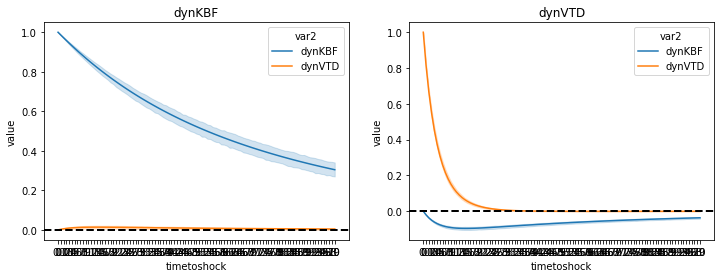

In [108]:
#together
df_plt = df_result[df_result['varComb'].isin(['dynVTD_dynVTD','dynKBF_dynKBF','dynKBF_dynVTD','dynVTD_dynKBF'])].copy()
c = 2 ; l = 1 ; img_w = 6 ; img_h = 4
fig = plt.figure(figsize=(img_w*c, img_h*l))
plt.subplot(l,c,1)
sns.lineplot(x='timetoshock', y='value', hue='var2',data=df_plt[df_plt['var1']=='dynKBF']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynKBF')
plt.subplot(l,c,2)
sns.lineplot(x='timetoshock', y='value', hue='var2',data=df_plt[df_plt['var1']=='dynVTD']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynVTD');

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)


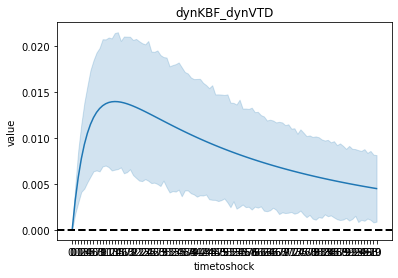

C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)


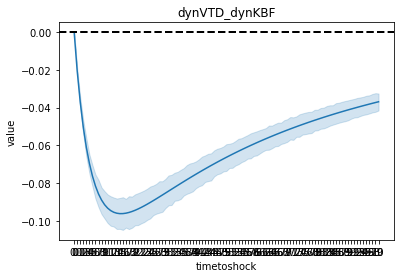

In [109]:
#separately
sns.lineplot(x='timetoshock', y='value', data=df_plt[df_plt['varComb']=='dynKBF_dynVTD']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynKBF_dynVTD')
plt.show()
sns.lineplot(x='timetoshock', y='value', data=df_plt[df_plt['varComb']=='dynVTD_dynKBF']);
plt.axhline(y=0, xmin=0, xmax=10, linewidth=2, color='black', linestyle='--')
plt.title('dynVTD_dynKBF');

## 1. compare with real data

In [57]:
#do scatter plot age kbf age vtd and kbf vtd....
#do tsem with age instead of vtd!

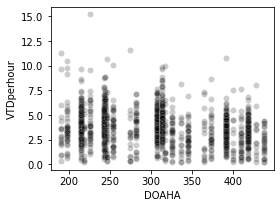

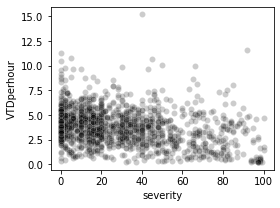

In [58]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='VTDperhour', color='black', data=df_init, alpha=0.2);
plt.figure(figsize=(4,3))
sns.scatterplot(x='severity', y='VTDperhour', color='black', data=df_init, alpha=0.2);
#--> VTDperhour reduce more over severity than DOAHA. I believe the model: the more severe the lesser you move

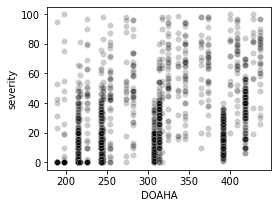

In [59]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='severity', color='black', data=df_init, alpha=0.2);

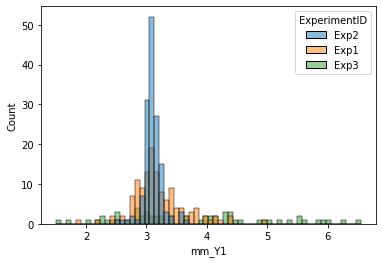

In [60]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

### TICov differ?

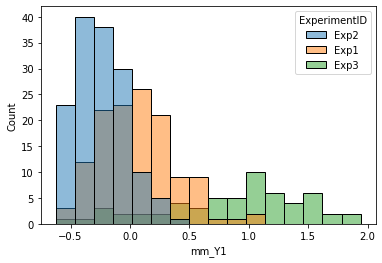

In [11]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

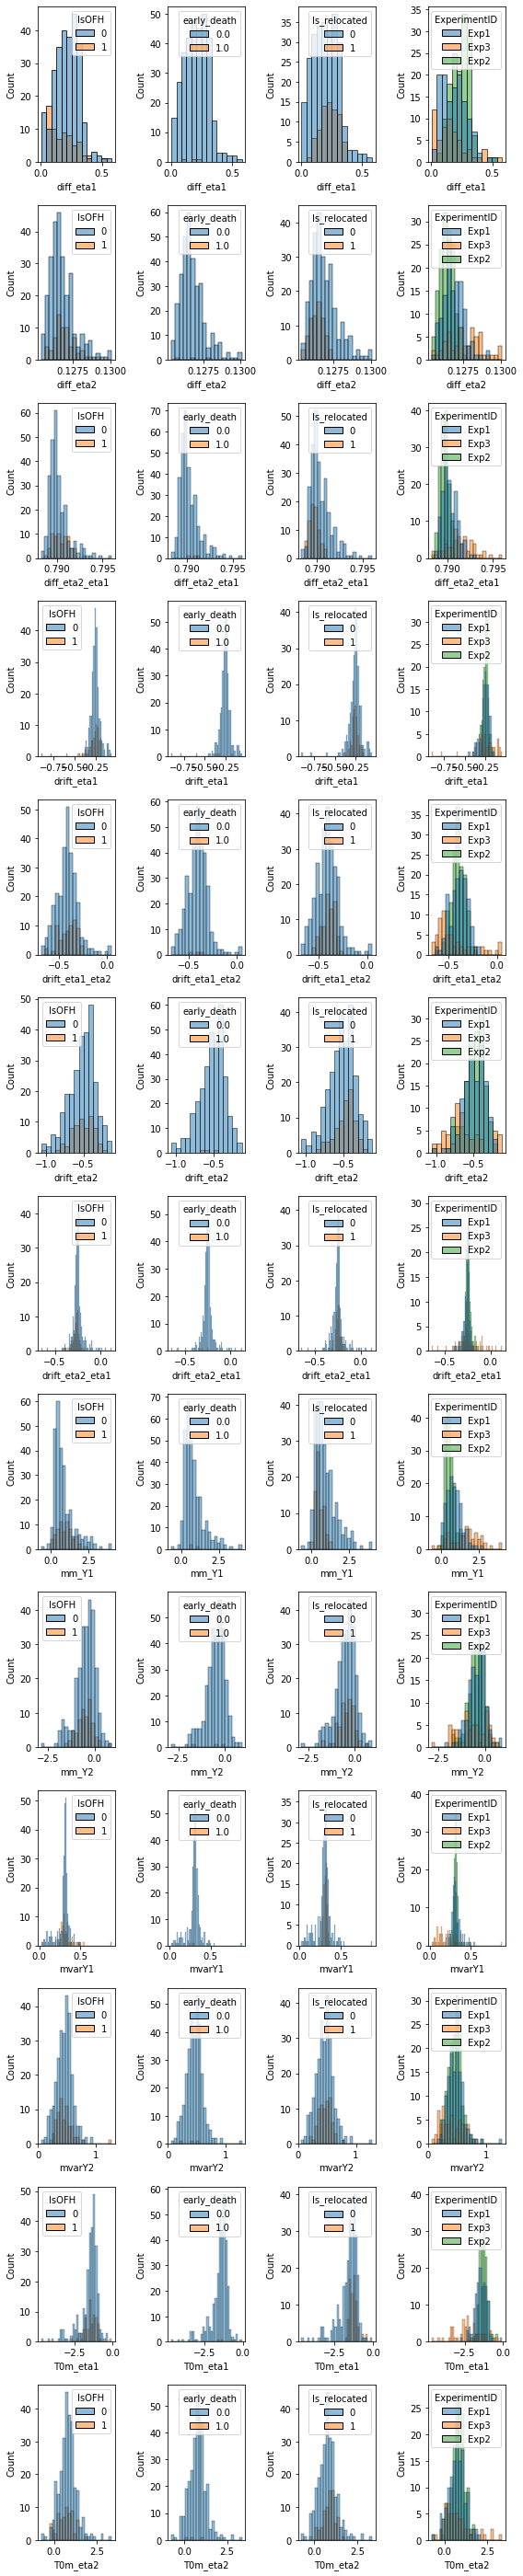

In [7]:
li_cov = ['IsOFH','early_death','Is_relocated','ExperimentID']
c = len(li_cov) ; l = len(li_indestimate)
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v in li_indestimate:
    for h in li_cov:
        plt.subplot(l,c,i)
        plt.tight_layout()
        #plt.figure(figsize=(2,3))
        #plt.grid(True)
        #plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
        #sns.displot(df, x=v, hue=h, kind="kde", fill=True); #does not work, shouldspecify axis
        sns.histplot(df, x=v, hue=h, fill=True); 
        i = i+1
plt.savefig(os.path.join(path_save,name+'TICovdifference.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

### Var in mvt associates with mean in KBF?

SpearmanrResult(correlation=0.969268401478608, pvalue=2.807157095939286e-204)
PearsonRResult(statistic=0.9302453759131697, pvalue=1.3093063211915346e-146)
-------------------------
SpearmanrResult(correlation=-0.13956322932996454, pvalue=0.01066285438832268)
PearsonRResult(statistic=-0.29902125485652775, pvalue=2.51351941617484e-08)
-------------------------
SpearmanrResult(correlation=-0.04857521745536761, pvalue=0.37618960538908186)
PearsonRResult(statistic=-0.24716134883335122, pvalue=4.848909121812093e-06)


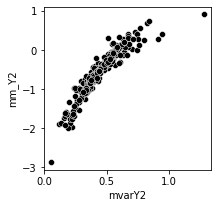

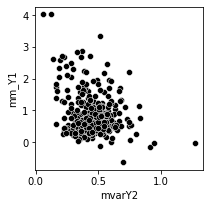

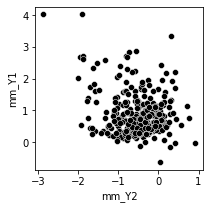

In [8]:
#does hens that have more variation in VTD have lesser intercept of KBF?
#MAYBE: TODO: add all data, and test if mvarY1 or T0var exhibit a different drift
#color='black',hue=df['ExperimentID'].tolist()
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y2', color='black', data=df); #hens that vary a lot have higher mvt
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y2'].tolist())) #stats on stats, but we have the real correlation in the results
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y2'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y1', color='black', data=df); #hens that vary a lot may have lower intercept of KBF
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mm_Y2', y='mm_Y1', color='black',data=df); #hens that have a higher VTD interecept, do not have more or less KBF
print(spearmanr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))

### does hens that have lower VTD have a stronger influence of their mvt on the KBF?

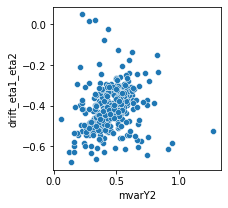

In [9]:
#does hens that have lower VTD have a stronger influence of their mvt on the KBF?
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2',y='drift_eta1_eta2', data=df);
# not so clear

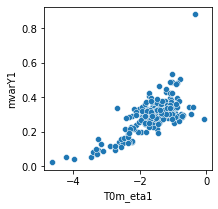

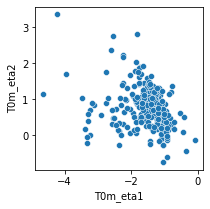

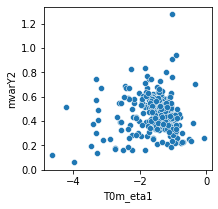

In [10]:
#TODO: THINK ABOUT
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY1', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='T0m_eta2', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY2', data=df);

### mm_- baseline level: ind diff in intercept

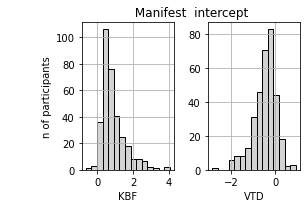

In [20]:
# mm_ : Manifest  means (mm) show the continuous manifest intercept, reflecting between-ind. differences in  baseline levels
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mm_Y1','mm_Y2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                 Manifest  intercept')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()
#KBF is postive meaning thatKBF

### mvar_ - var/cov of manifest indicators

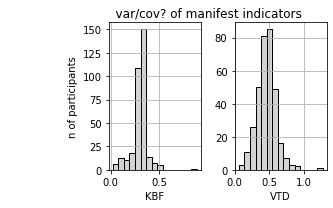

In [12]:
### mvar : variance of manifest indicators reflects the within-person variability in measurement error, and unsurprisingly, 
#it is higher for KBF, indicating that measures of  KBF  tend  to  fluctuate more 
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mvarY1','mvarY2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                            var/cov? of manifest indicators')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

# T0m_ - initial stage w.r.t later stages

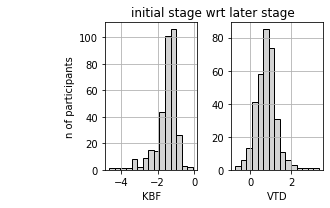

In [13]:
#T0m_eta2  is  the  initial  stage  of  the VTD latent  processe with  respect  to  later stages. Positive  values  indicate  
#that  initial  level  of  VTD  is  higher  than  at  later  stages,  i.e.  VTD  diminish  as  time  goes  by.
#DONT confuse initial stage with starting values...
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['T0m_eta1','T0m_eta2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                initial stage wrt later stage')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

# drift - change over time

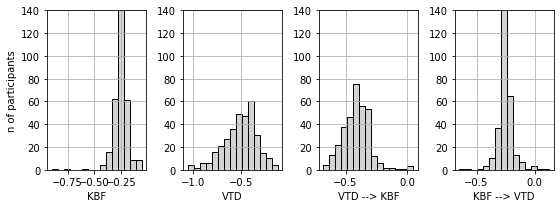

In [14]:
#distribution individual continuous time auto-effects
c = 4 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['drift_eta1','drift_eta2','drift_eta1_eta2','drift_eta2_eta1'],['KBF','VTD','VTD --> KBF','KBF --> VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
    plt.xlabel(name_plt)
    i = i+1
    plt.ylim(0,140)
plt.savefig(os.path.join(path_save,name+'distribution_individual_continuous_autoeffect.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()